#kaggle竞赛泰坦尼克号宇宙飞船

In [3]:
#数据处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('train.csv').drop('PassengerId',axis=1)
test = pd.read_csv('test.csv')


=== 数据基本信息 ===
数据形状: (8693, 13)

缺失值统计:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Transported分布:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

正在生成类别特征可视化...


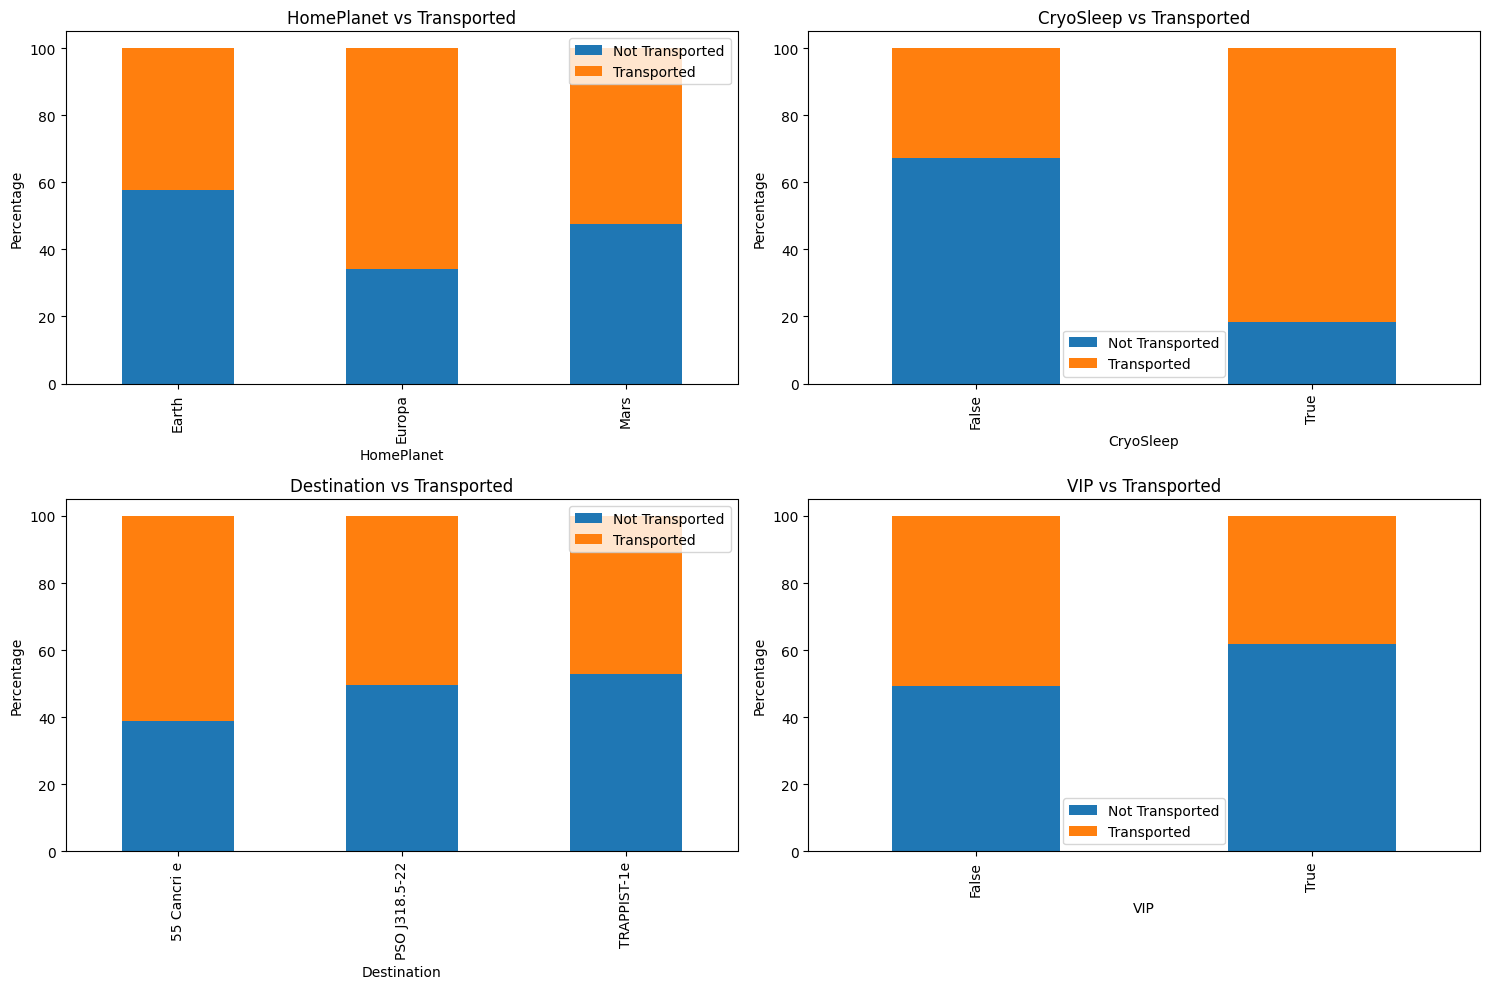


正在生成数值特征可视化...


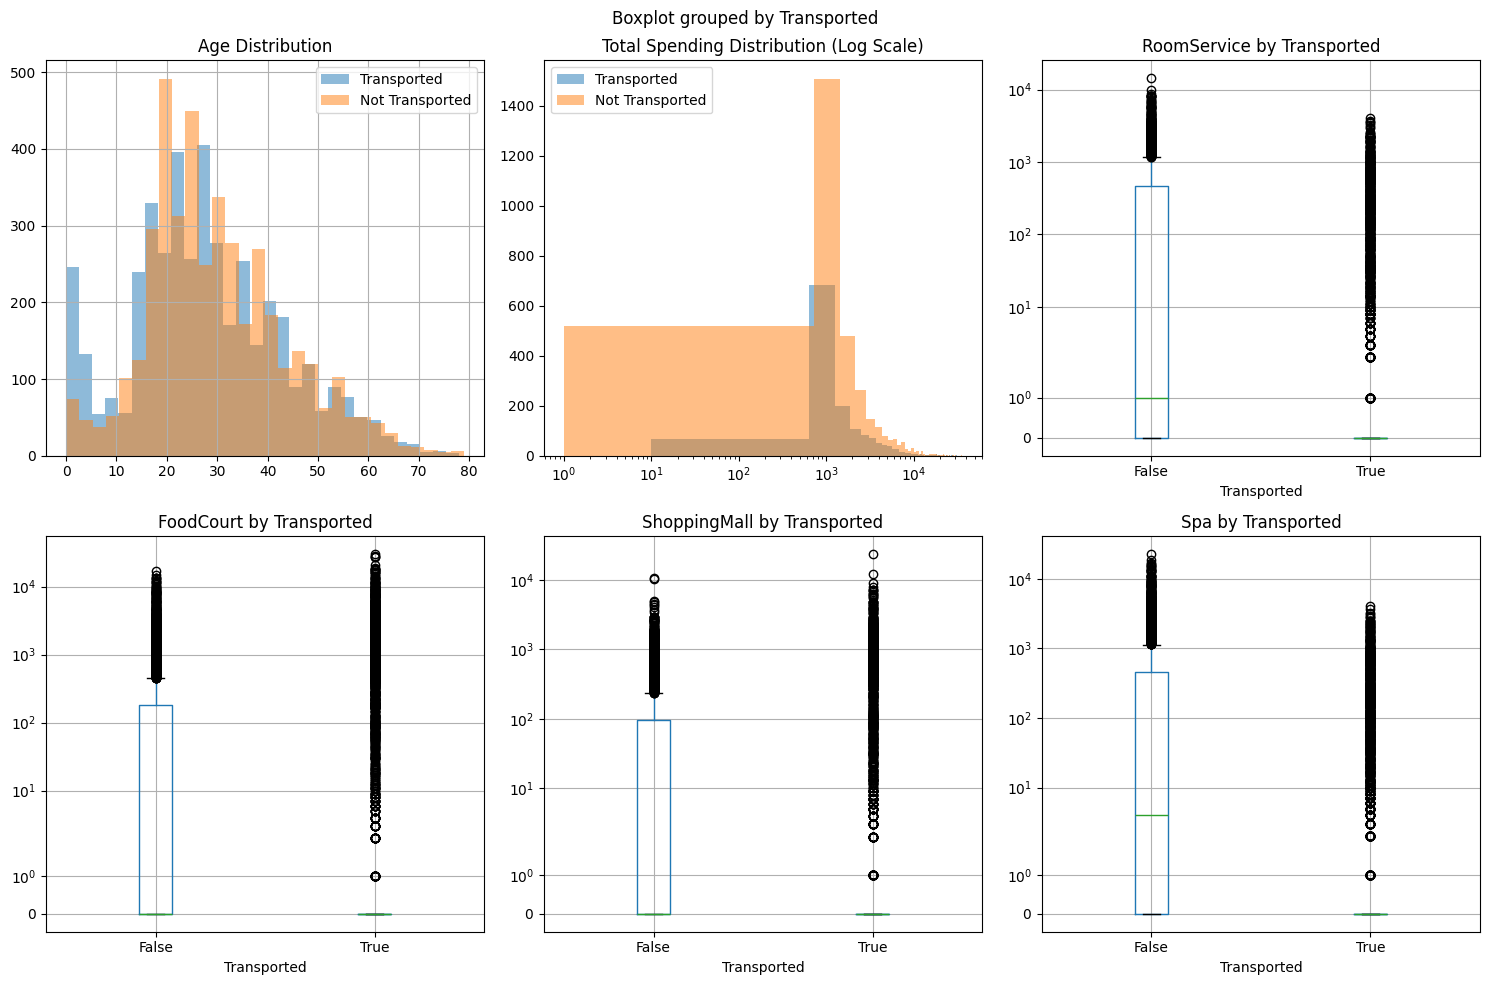


=== 特征重要性排名 ===
ZeroSpending: 卡方值=2014.53, p值=0.0000
CryoSleep: 卡方值=1859.61, p值=0.0000
HomePlanet: 卡方值=324.90, p值=0.0000
Destination: 卡方值=106.39, p值=0.0000
VIP: 卡方值=11.54, p值=0.0007
RoomService: 相关系数=0.2420
Spa: 相关系数=0.2188
VRDeck: 相关系数=0.2048
Age: 相关系数=0.0742
FoodCourt: 相关系数=0.0461
ShoppingMall: 相关系数=0.0100

=== 特征洞察 ===

CryoSleep运输率:
Transported     False     True 
CryoSleep                      
False        0.671079  0.328921
True         0.182417  0.817583

零消费运输率:
Transported      False     True 
ZeroSpending                    
False         0.701389  0.298611
True          0.213523  0.786477

各母星运输率:
Transported     False     True 
HomePlanet                     
Earth        0.576054  0.423946
Europa       0.341154  0.658846
Mars         0.476976  0.523024


In [5]:
#可视化方法检查数据重要性
def quick_eda(df, target='Transported'):
    """快速探索性数据分析"""
    print("\n=== 数据基本信息 ===")
    print(f"数据形状: {df.shape}")
    print(f"\n缺失值统计:")
    print(df.isnull().sum())

    # 目标变量分布
    print(f"\n{target}分布:")
    print(df[target].value_counts(normalize=True))


def plot_categorical_features(df, target='Transported', figsize=(15, 10)):
    """可视化类别特征与目标变量的关系"""
    # 识别类别特征
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()

    for idx, feature in enumerate(cat_features):
        # 计算每个类别的目标变量比例
        cross_tab = pd.crosstab(df[feature], df[target], normalize='index') * 100

        # 绘制堆叠条形图
        cross_tab.plot(kind='bar', stacked=True, ax=axes[idx])
        axes[idx].set_title(f'{feature} vs {target}')
        axes[idx].set_ylabel('Percentage')
        axes[idx].legend(['Not Transported', 'Transported'])

    plt.tight_layout()
    plt.show()


def plot_numerical_features(df, target='Transported', figsize=(15, 10)):
    """可视化数值特征与目标变量的关系"""
    # 数值特征
    num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # 创建总消费特征
    # Check if the spending columns exist before summing
    spending_cols_for_sum = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    present_spending_cols_for_sum = [col for col in spending_cols_for_sum if col in df.columns]
    if present_spending_cols_for_sum:
        df['TotalSpending'] = df[present_spending_cols_for_sum].sum(axis=1)


    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()

    # 年龄分布
    if 'Age' in df.columns and target in df.columns:
        df[df[target] == True]['Age'].hist(bins=30, alpha=0.5, label='Transported', ax=axes[0])
        df[df[target] == False]['Age'].hist(bins=30, alpha=0.5, label='Not Transported', ax=axes[0])
        axes[0].set_title('Age Distribution')
        axes[0].legend()
    else:
        axes[0].set_title('Age Distribution (Data Missing)')


    # 总消费分布（对数刻度）
    if 'TotalSpending' in df.columns and target in df.columns:
        for transported in [True, False]:
            spending = df[df[target] == transported]['TotalSpending']
            spending = spending[spending > 0]  # 只显示非零消费
            axes[1].hist(spending, bins=50, alpha=0.5,
                        label='Transported' if transported else 'Not Transported')
        axes[1].set_xscale('log')
        axes[1].set_title('Total Spending Distribution (Log Scale)')
        axes[1].legend()
    else:
         axes[1].set_title('Total Spending Distribution (Data Missing)')


    # 各项消费的箱线图
    # There are 4 axes remaining (indices 2, 3, 4, 5) for the box plots
    # num_features[1:] has 5 features, so we can only plot 4 of them.
    # We will plot the first 4 features in num_features[1:]
    features_for_boxplot = num_features[1:5] # Select RoomService, FoodCourt, ShoppingMall, Spa

    for idx, feature in enumerate(features_for_boxplot):
        if feature in df.columns and target in df.columns:
            df.boxplot(column=feature, by=target, ax=axes[idx+2]) # Use axes[2], axes[3], axes[4], axes[5]
            axes[idx+2].set_title(f'{feature} by {target}')
            axes[idx+2].set_yscale('symlog')  # 对称对数刻度，处理零值
        else:
            axes[idx+2].set_title(f'{feature} by {target} (Data Missing)')


    plt.tight_layout()
    plt.show()


def calculate_feature_importance(df, target='Transported'):
    """计算特征重要性（简化版）"""
    from scipy.stats import chi2_contingency

    importance_scores = {}

    # 处理布尔值
    df_copy = df.copy()
    bool_cols = ['CryoSleep', 'VIP', 'Transported']
    for col in bool_cols:
        if col in df_copy.columns:
            # Ensure the column exists before attempting to map
            if not df_copy[col].isnull().all(): # Only map if there are non-null values
                 df_copy[col] = df_copy[col].map({True: 1, False: 0}) # Removed 'True'/'False' strings as the dataframe has actual booleans

    # 类别特征 - 使用卡方检验
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
    for feature in cat_features:
        if feature in df_copy.columns and target in df_copy.columns:
            # Create contingency table, dropping NA values in the feature column and target
            contingency = pd.crosstab(df_copy[feature].dropna(), df_copy[target].dropna())
            # Ensure the contingency table is not empty before performing chi2 test
            if not contingency.empty:
                 chi2, p_value, _, _ = chi2_contingency(contingency)
                 importance_scores[feature] = {'score': chi2, 'p_value': p_value}


    # 数值特征 - 使用相关系数
    num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    # Corrected loop: Iterate through the num_features list and check if the column exists in df_copy
    for feature in num_features:
        if feature in df_copy.columns and target in df_copy.columns: # Check if the feature and target are in df_copy
             # Calculate correlation, filling NA values with the mean of the column
             # Filling with mean is generally better than 0 for correlation
             corr = abs(df_copy[feature].fillna(df_copy[feature].mean()).corr(df_copy[target]))
             importance_scores[feature] = {'score': corr, 'type': 'correlation'}


    # 创建总消费特征
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    # Ensure spending_cols are present before summing
    present_spending_cols = [col for col in spending_cols if col in df_copy.columns]
    if present_spending_cols:
        df_copy['TotalSpending'] = df_copy[present_spending_cols].sum(axis=1)
        df_copy['ZeroSpending'] = (df_copy['TotalSpending'] == 0).astype(int)

        # 零消费特征的重要性
        # Create contingency table for ZeroSpending and Transported
        if 'ZeroSpending' in df_copy.columns and target in df_copy.columns:
            contingency_zero_spending = pd.crosstab(df_copy['ZeroSpending'], df_copy[target].dropna()) # Drop NA from target
            # Ensure the contingency table is not empty
            if not contingency_zero_spending.empty:
                chi2, p_value, _, _ = chi2_contingency(contingency_zero_spending)
                importance_scores['ZeroSpending'] = {'score': chi2, 'p_value': p_value}


    # 排序并显示
    # Check if importance_scores is not empty before sorting
    if importance_scores:
        sorted_features = sorted(importance_scores.items(),
                               key=lambda x: x[1]['score'],
                               reverse=True)

        print("\n=== 特征重要性排名 ===")
        for feature, stats in sorted_features:
            if 'p_value' in stats:
                print(f"{feature}: 卡方值={stats['score']:.2f}, p值={stats['p_value']:.4f}")
            else:
                print(f"{feature}: 相关系数={stats['score']:.4f}")
    else:
        print("\n=== 特征重要性排名 ===")
        print("无法计算特征重要性，请检查数据和目标列。")


    return importance_scores


def get_feature_insights(df, target='Transported'):
    """获取特征洞察和建议"""
    print("\n=== 特征洞察 ===")

    # CryoSleep分析
    if 'CryoSleep' in df.columns and target in df.columns:
        # Drop NA from CryoSleep and target before value_counts
        cryo_stats = df.dropna(subset=['CryoSleep', target]).groupby('CryoSleep')[target].value_counts(normalize=True).unstack()
        print(f"\nCryoSleep运输率:")
        print(cryo_stats)
    else:
        print("\n'CryoSleep' or 'Transported' column not found or data missing for CryoSleep analysis.")


    # 消费分析
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    # Ensure spending_cols are present before summing
    present_spending_cols = [col for col in spending_cols if col in df.columns]
    if present_spending_cols:
        # Create TotalSpending without modifying the original df for the insight function
        df_temp = df.copy()
        df_temp['TotalSpending'] = df_temp[present_spending_cols].sum(axis=1)
        df_temp['ZeroSpending'] = df_temp['TotalSpending'] == 0

        if 'ZeroSpending' in df_temp.columns and target in df_temp.columns:
            # Drop NA from ZeroSpending and target before value_counts
            zero_spending_rate = df_temp.dropna(subset=['ZeroSpending', target]).groupby('ZeroSpending')[target].value_counts(normalize=True).unstack()
            print(f"\n零消费运输率:")
            print(zero_spending_rate)
        else:
             print("\n'ZeroSpending' or 'Transported' column not found or data missing for zero spending analysis.")
    else:
        print("\nNone of the spending columns found for spending analysis.")

    # HomePlanet分析
    if 'HomePlanet' in df.columns and target in df.columns:
        # Drop NA from HomePlanet and target before value_counts
        planet_stats = df.dropna(subset=['HomePlanet', target]).groupby('HomePlanet')[target].value_counts(normalize=True).unstack()
        print(f"\n各母星运输率:")
        print(planet_stats)
    else:
        print("\n'HomePlanet' or 'Transported' column not found or data missing for HomePlanet analysis.")



# 运行分析
if __name__ == "__main__":
    # 快速概览
    quick_eda(data)

    # 可视化
    print("\n正在生成类别特征可视化...")
    plot_categorical_features(data)

    print("\n正在生成数值特征可视化...")
    plot_numerical_features(data)

    # 特征重要性
    importance = calculate_feature_importance(data)

    # 特征洞察
    get_feature_insights(data)

In [6]:
import pandas as pd
import numpy as np

def process_features(df):
    """
    简化版特征工程，专注于最重要的三个特征

    参数:
    -----
    df : pandas.DataFrame
        输入数据框

    返回:
    -----
    pandas.DataFrame
        处理后的数据框，包含原始特征和三个新特征
    """
    # 创建数据副本
    data = df.copy()

    # 特征1: 零消费 (最重要特征，卡方值=2014.53)
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    # 处理数值特征中的缺失值
    for col in spending_cols + ['Age']:
        if col in data.columns:
            data[col] = data[col].fillna(0)

    # 创建零消费特征
    data['TotalSpending'] = data[spending_cols].sum(axis=1)
    data['ZeroSpending'] = (data['TotalSpending'] == 0).astype(int)

    # 特征2: 低温睡眠 (第二重要特征，卡方值=1859.61)
    if 'CryoSleep' in data.columns:
        # 处理缺失值
        data['CryoSleep'] = data['CryoSleep'].fillna('False')
        # 编码
        data['CryoSleep'] = data['CryoSleep'].map({'True': 1, 'False': 0, True: 1, False: 0})

    # 特征3: 母星 (第三重要特征，卡方值=324.90)
    if 'HomePlanet' in data.columns:
        # 处理缺失值
        data['HomePlanet'] = data['HomePlanet'].fillna('Earth')  # 使用最常见值填充
        # 编码: 将Europa编码为2，因为从该星球来的乘客更可能被传送
        planet_map = {'Europa': 2, 'Mars': 1, 'Earth': 0}
        data['HomePlanet'] = data['HomePlanet'].map(planet_map).fillna(0).astype(int)

    # 返回处理后的数据
    return data

In [7]:
data = pd.read_csv('train.csv').drop('PassengerId',axis=1)
data_processed = (process_features(data))
data_train,data_eval = train_test_split(data_processed,test_size=0.2)#数据集分为训练和评估集


test = pd.read_csv('test.csv')
test_processed = process_features(test).drop('PassengerId',axis=1)
test_id = test.pop('PassengerId')

print(data.shape, test.shape,test_id.shape)#数据集，测试集,测试集id
print(data_train.shape, data_eval.shape)#训练，评估集
print(test_processed.shape)#测试集

data_processed.head(20)

(8693, 13) (4277, 12) (4277,)
(6954, 15) (1739, 15)
(4277, 14)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,TotalSpending,ZeroSpending
0,2,0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,1
1,0,0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,0
2,2,0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,0
3,2,0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,0
4,0,0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,0
5,0,0,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,774.0,0
6,0,0,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,1584.0,0
7,0,1,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Candra Jacostaffey,True,0.0,1
8,0,0,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,1018.0,0
9,2,1,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,0.0,1


In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 数据类型转换函数
def prepare_data_for_lgbm(data):
    """
    准备数据为LightGBM可接受的格式，并处理NaN值
    """
    df = data.copy()

    # 先处理所有NaN值
    # 对数值列使用0填充
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col] = df[col].fillna(0)

    # 对分类列使用众数填充
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
    for col in categorical_cols:
        if col not in ['Cabin', 'Name', 'Destination']:  # 这些列稍后会删除
            # 使用众数填充，如果无众数则用"Unknown"
            if df[col].dropna().empty:
                most_common = "Unknown"
            else:
                most_common = df[col].dropna().mode()[0]
            df[col] = df[col].fillna(most_common)

    # 处理VIP特征 - 转换为数值型
    if 'VIP' in df.columns:
        df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0}).fillna(0).astype(int)

    # 检查并转换所有object类型的列
    for col in df.select_dtypes(include=['object']).columns:
        if col not in ['Cabin', 'Name', 'Destination']:  # 这些列稍后会删除
            print(f"Converting column {col} from object to numeric")
            unique_values = df[col].unique()
            print(f"  Unique values: {unique_values}")

            # 使用映射转换为数值
            value_map = {val: i for i, val in enumerate(unique_values) if pd.notna(val)}
            # 处理NaN值
            df[col] = df[col].map(lambda x: value_map.get(x, 0) if pd.notna(x) else 0).astype(int)
            print(f"  Mapped to: {value_map}")

    # 确保Transported列是bool类型或int类型
    if 'Transported' in df.columns:
        if df['Transported'].dtype == 'object':
            df['Transported'] = df['Transported'].map({'True': True, 'False': False, True: True, False: False})

    return df

# 应用转换
data_train_prepared = prepare_data_for_lgbm(data_train)
data_eval_prepared = prepare_data_for_lgbm(data_eval)
test_processed_prepared = prepare_data_for_lgbm(test_processed)

# 准备训练数据和验证数据
# 只去掉不需要的特征
X_train = data_train_prepared.drop(['Transported', 'Cabin', 'Name', 'Destination'], axis=1)
y_train = data_train_prepared['Transported'].astype(int)

X_eval = data_eval_prepared.drop(['Transported', 'Cabin', 'Name', 'Destination'], axis=1)
y_eval = data_eval_prepared['Transported'].astype(int)

# 打印列的数据类型，确保没有object类型
print("X_train数据类型:")
print(X_train.dtypes)

# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_eval, label=y_eval, reference=train_data)

# 设置LightGBM参数
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'max_depth': -1,  # 无限制
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# 训练模型
print("开始训练LightGBM模型...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, eval_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 在验证集上评估模型
y_pred_proba = model.predict(X_eval, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

# 计算准确率
accuracy = accuracy_score(y_eval, y_pred)
print(f"验证集准确率: {accuracy:.4f}")
print("\n分类报告:")
print(classification_report(y_eval, y_pred))

<ipython-input-13-6b6e59eb3e11>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(most_common)
<ipython-input-13-6b6e59eb3e11>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(most_common)
<ipython-input-13-6b6e59eb3e11>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].

X_train数据类型:
HomePlanet         int64
CryoSleep          int64
Age              float64
VIP                int64
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
TotalSpending    float64
ZeroSpending       int64
dtype: object
开始训练LightGBM模型...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.37222	valid_1's binary_logloss: 0.432041
验证集准确率: 0.7901

分类报告:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       892
           1       0.76      0.83      0.79       847

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [14]:
X_test = test_processed_prepared.drop(['Cabin', 'Name', 'Destination'], axis=1)

test_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
test_pred = (test_pred_proba > 0.5).astype(bool)

# 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test_id,
    'Transported': test_pred
})

# 保存提交文件
submission.to_csv('lightgbm_submission.csv', index=False)
print("提交文件已创建!")

提交文件已创建!
